In [2]:
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
import pickle
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import os
import io

### Levanto las matrices de proximidad ya creadas

### <span style="color:steelblue">Dataset 1: </span>: todos los períodos - 109 países

En este caso las matrices reducidas (se extrajeron los productos con paths = 0) corresponden a 1217 productos. 

In [3]:
list_years1 = ['1719', '0709', '9799']
# levanto las matrices y por ahora descarto las descripciones
prox_matrix1 = {}
for i in list_years1:
    df = pd.read_csv(f'../data/processed/prox_matix_desc_{i}_df1.csv')
    df = df.set_index(df.product_i)
    df = df.drop(columns=['product_i', 'HS_code', 'HS_description', 'es_bio_prod', 'Category', 'paths'])
    df = df.set_index(df.index.astype(str))
    prox_matrix1[i] = df

In [4]:
prox_matrix1['1719'] # me quedo solo con las matrices de proximidad limpias

101       102       103       104       105       106  \
product_i                                                               
101        1.000000  0.250000  0.277778  0.142857  0.266667  0.228571   
102        0.250000  1.000000  0.416667  0.361111  0.444444  0.388889   
103        0.277778  0.416667  1.000000  0.190476  0.300000  0.285714   
104        0.142857  0.361111  0.190476  1.000000  0.433333  0.285714   
105        0.266667  0.444444  0.300000  0.433333  1.000000  0.485714   
...             ...       ...       ...       ...       ...       ...   
9702       0.294118  0.027778  0.055556  0.000000  0.066667  0.057143   
9703       0.235294  0.083333  0.000000  0.095238  0.166667  0.142857   
9704       0.470588  0.166667  0.222222  0.047619  0.133333  0.085714   
9705       0.352941  0.111111  0.055556  0.142857  0.300000  0.171429   
9706       0.235294  0.083333  0.055556  0.142857  0.166667  0.114286   

                201       202       203       204  ...      9615      9616  \
product_i                                          ...                       
101        0.454545  0.352941  0.294118  0.352941  ...  0.058824  0.058824   
102        0.444444  0.194444  0.222222  0.250000  ...  0.027778  0.083333   
103        0.409091  0.055556  0.388889  0.166667  ...  0.000000  0.111111   
104        0.181818  0.095238  0.095238  0.238095  ...  0.000000  0.095238   
105        0.366667  0.166667  0.333333  0.166667  ...  0.033333  0.100000   
...             ...       ...       ...       ...  ...       ...       ...   
9702       0.045455  0.066667  0.076923  0.066667  ...  0.142857  0.000000   
9703       0.136364  0.200000  0.153846  0.066667  ...  0.000000  0.153846   
9704       0.227273  0.200000  0.214286  0.333333  ...  0.000000  0.000000   
9705       0.227273  0.133333  0.307692  0.133333  ...  0.083333  0.083333   
9706       0.136364  0.066667  0.153846  0.066667  ...  0.090909  0.090909   

               9617      9618      9701      9702      9703      9704  \
product_i                                                               
101        0.000000  0.294118  0.294118  0.294118  0.235294  0.470588   
102        0.027778  0.166667  0.055556  0.027778  0.083333  0.166667   
103        0.055556  0.222222  0.000000  0.055556  0.000000  0.222222   
104        0.000000  0.142857  0.047619  0.000000  0.095238  0.047619   
105        0.033333  0.266667  0.100000  0.066667  0.166667  0.133333   
...             ...       ...       ...       ...       ...       ...   
9702       0.000000  0.125000  0.500000  1.000000  0.384615  0.285714   
9703       0.000000  0.187500  0.461538  0.384615  1.000000  0.214286   
9704       0.000000  0.187500  0.142857  0.285714  0.214286  1.000000   
9705       0.000000  0.250000  0.416667  0.333333  0.384615  0.357143   
9706       0.090909  0.187500  0.545455  0.363636  0.538462  0.142857   

               9705      9706  
product_i                      
101        0.352941  0.235294  
102        0.111111  0.083333  
103        0.055556  0.055556  
104        0.142857  0.142857  
105        0.300000  0.166667  
...             ...       ...  
9702       0.333333  0.363636  
9703       0.384615  0.538462  
9704       0.357143  0.142857  
9705       1.000000  0.583333  
9706       0.583333  1.000000  

[1217 rows x 1217 columns]

In [5]:
# creo un dataframe con los nodos de entrada, salida y pesos por cada periodo
edge_df_tot = pd.DataFrame()
for i in list_years1:
    edge_list = prox_matrix1[i].unstack()
    # elimino los llamados a si mismo para obtener solo nodos i y j 
    edge_list = edge_list[edge_list != 1.0] 
    edge_list = edge_list.reset_index()
    edge_list.columns = ["Pi","Pj","prox"]
    # agrego una columna de año para saber de que periodo se trata
    edge_list['years'] = np.repeat(str(i), len(edge_list))
    edge_df_tot = edge_df_tot.append(edge_list)    

In [6]:
edge_df_tot.years.unique()

array(['1719', '0709', '9799'], dtype=object)

In [7]:
edge_df_tot

Pi    Pj      prox years
0         101   102  0.250000  1719
1         101   103  0.277778  1719
2         101   104  0.142857  1719
3         101   105  0.266667  1719
4         101   106  0.228571  1719
...       ...   ...       ...   ...
1479867  9706  9701  0.375000  9799
1479868  9706  9702  0.300000  9799
1479869  9706  9703  0.166667  9799
1479870  9706  9704  0.187500  9799
1479871  9706  9705  0.166667  9799

[4439616 rows x 4 columns]

In [8]:
edge_df_tot.loc[edge_df_tot.years=='1719'][["prox"]]

prox
0        0.250000
1        0.277778
2        0.142857
3        0.266667
4        0.228571
...           ...
1479867  0.545455
1479868  0.363636
1479869  0.538462
1479870  0.142857
1479871  0.583333

[1479872 rows x 1 columns]

In [9]:
# pruebas con 1719 para luego escalar a todos los restantes datasets
edge_list_1719 = prox_matrix1['1719'].unstack()
edge_list_1719

      product_i
101   101          1.000000
      102          0.250000
      103          0.277778
      104          0.142857
      105          0.266667
                     ...   
9706  9702         0.363636
      9703         0.538462
      9704         0.142857
      9705         0.583333
      9706         1.000000
Length: 1481089, dtype: float64

In [10]:
edge_list_1719 = edge_list_1719[edge_list_1719 != 1.0] # elimino los llamados a si mismo para obtener solo nodos i y j  
edge_list_1719 = edge_list_1719.reset_index()
edge_list_1719.columns = ["Pi","Pj","prox"]
edge_list_1719

Pi    Pj      prox
0         101   102  0.250000
1         101   103  0.277778
2         101   104  0.142857
3         101   105  0.266667
4         101   106  0.228571
...       ...   ...       ...
1479867  9706  9701  0.545455
1479868  9706  9702  0.363636
1479869  9706  9703  0.538462
1479870  9706  9704  0.142857
1479871  9706  9705  0.583333

[1479872 rows x 3 columns]

In [11]:
edge_list_1719['year'] = np.repeat('1719', len(edge_list_1719)) 
edge_list_1719

Pi    Pj      prox  year
0         101   102  0.250000  1719
1         101   103  0.277778  1719
2         101   104  0.142857  1719
3         101   105  0.266667  1719
4         101   106  0.228571  1719
...       ...   ...       ...   ...
1479867  9706  9701  0.545455  1719
1479868  9706  9702  0.363636  1719
1479869  9706  9703  0.538462  1719
1479870  9706  9704  0.142857  1719
1479871  9706  9705  0.583333  1719

[1479872 rows x 4 columns]

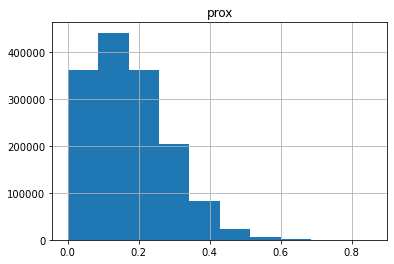

In [12]:
edge_list_1719[["prox"]].hist(); # como se distribuye nuestra medida de proximidad
# esto ya lo hice para todos en el notebook Visualización de matrices de proximidad, solo para chequear 

In [13]:
# cantidad de valores = 0 
sum(i == 0.0 for i in edge_list_1719[["prox"]].unstack()) / sum(i < 1.0 for i in edge_list_1719[["prox"]].unstack())* 100 

8.293960558751028

In [14]:
# cantidad de valores menores a 0.1
sum(i < 0.1 for i in edge_list_1719[["prox"]].unstack()) / sum(i < 1.0 for i in edge_list_1719[["prox"]].unstack())* 100 

28.005665354841504

In [15]:
# cantidad de valores menores a 0.2
sum(i < 0.2 for i in edge_list_1719[["prox"]].unstack()) / sum(i < 1.0 for i in edge_list_1719[["prox"]].unstack())* 100 

61.73385265752713

In [16]:
# número máximo de links
max_links = (prox_matrix1['1719'].shape[0]*prox_matrix1['1719'].shape[0]-prox_matrix1['1719'].shape[0])//2 
max_links

739936

**numpy.tril_indices(n, k=0, m=None)**

Devuelve los índices del triángulo inferior de una matriz (n, m). Por lo que, para los cálculos sólo se toman los valores del triángulo inferior. 

[source](https://numpy.org/doc/stable/reference/generated/numpy.tril_indices.html)

In [17]:
# pruebo con un ejemplo para luego escalar
X = prox_matrix1['1719']

In [18]:
X

101       102       103       104       105       106  \
product_i                                                               
101        1.000000  0.250000  0.277778  0.142857  0.266667  0.228571   
102        0.250000  1.000000  0.416667  0.361111  0.444444  0.388889   
103        0.277778  0.416667  1.000000  0.190476  0.300000  0.285714   
104        0.142857  0.361111  0.190476  1.000000  0.433333  0.285714   
105        0.266667  0.444444  0.300000  0.433333  1.000000  0.485714   
...             ...       ...       ...       ...       ...       ...   
9702       0.294118  0.027778  0.055556  0.000000  0.066667  0.057143   
9703       0.235294  0.083333  0.000000  0.095238  0.166667  0.142857   
9704       0.470588  0.166667  0.222222  0.047619  0.133333  0.085714   
9705       0.352941  0.111111  0.055556  0.142857  0.300000  0.171429   
9706       0.235294  0.083333  0.055556  0.142857  0.166667  0.114286   

                201       202       203       204  ...      9615      9616  \
product_i                                          ...                       
101        0.454545  0.352941  0.294118  0.352941  ...  0.058824  0.058824   
102        0.444444  0.194444  0.222222  0.250000  ...  0.027778  0.083333   
103        0.409091  0.055556  0.388889  0.166667  ...  0.000000  0.111111   
104        0.181818  0.095238  0.095238  0.238095  ...  0.000000  0.095238   
105        0.366667  0.166667  0.333333  0.166667  ...  0.033333  0.100000   
...             ...       ...       ...       ...  ...       ...       ...   
9702       0.045455  0.066667  0.076923  0.066667  ...  0.142857  0.000000   
9703       0.136364  0.200000  0.153846  0.066667  ...  0.000000  0.153846   
9704       0.227273  0.200000  0.214286  0.333333  ...  0.000000  0.000000   
9705       0.227273  0.133333  0.307692  0.133333  ...  0.083333  0.083333   
9706       0.136364  0.066667  0.153846  0.066667  ...  0.090909  0.090909   

               9617      9618      9701      9702      9703      9704  \
product_i                                                               
101        0.000000  0.294118  0.294118  0.294118  0.235294  0.470588   
102        0.027778  0.166667  0.055556  0.027778  0.083333  0.166667   
103        0.055556  0.222222  0.000000  0.055556  0.000000  0.222222   
104        0.000000  0.142857  0.047619  0.000000  0.095238  0.047619   
105        0.033333  0.266667  0.100000  0.066667  0.166667  0.133333   
...             ...       ...       ...       ...       ...       ...   
9702       0.000000  0.125000  0.500000  1.000000  0.384615  0.285714   
9703       0.000000  0.187500  0.461538  0.384615  1.000000  0.214286   
9704       0.000000  0.187500  0.142857  0.285714  0.214286  1.000000   
9705       0.000000  0.250000  0.416667  0.333333  0.384615  0.357143   
9706       0.090909  0.187500  0.545455  0.363636  0.538462  0.142857   

               9705      9706  
product_i                      
101        0.352941  0.235294  
102        0.111111  0.083333  
103        0.055556  0.055556  
104        0.142857  0.142857  
105        0.300000  0.166667  
...             ...       ...  
9702       0.333333  0.363636  
9703       0.384615  0.538462  
9704       0.357143  0.142857  
9705       1.000000  0.583333  
9706       0.583333  1.000000  

[1217 rows x 1217 columns]

In [19]:
# sorted(X.values[np.tril_indices(X.shape[0],-1)]) # paso la matriz a una dimensión -solo la mitad de la matriz, sin repeticiones- y la ordeno 

In [20]:
int(0.1*(X.shape[0]*X.shape[0]-X.shape[0])//2) # para calcular a distintas desidades, el numero de enlaces

73993

In [21]:
# para calcular los umbrales según la densidad de aristas definidas -ej. con densidad = 0.1-
sorted(X.values[np.tril_indices(X.shape[0],-1)])[int(0.1*(X.shape[0]*X.shape[0]-X.shape[0])//2)] 

0.04

### Pruebo armar grafos a distintas densidades de aristas

Cabe recordar, que en el paper original utilizan como umbral 0.55 para representar.

Para ofrecer una visualización en la que se incluyen todos los productos (en ese caso 775), llegan a todos los nodos calculando el árbol de expansión máxima, que incluye los 774 enlaces maximizando la proximidad agregada del árbol y superpuestos sobre él todos los enlaces con una proximidad mayor a 0.55. Ese conjunto de 1525 enlaces se utiliza para visualizar la estructura de la matriz de proximidad completa, que está lejos de ser homogénea y parece tener una estructura centro-periferia.

In [22]:
# armo funcion para crear grafos a distintos niveles de densidad de aristas con lista
def grafos_pordensidad(proximity_matrix:pd.DataFrame, densities:list):
    # cantidad de filas de la matriz (es una matriz cuadrada, así que filas==columnas)
    n = proximity_matrix.shape[0]
    # máxima cantidad de links
    max_links = (n*n-n)//2 
    # conserva la mitad de la matriz (sin repeticiones)
    tril_idx = np.tril_indices(n,-1) 
    # lo paso a una dimensión y ordeno
    sorted_proximities = sorted(proximity_matrix.values[tril_idx].flatten(),reverse=True)
    # genero grafos y los guardo en lista 
    Gs = []
    for d in densities:
        # pruebo con distinto número de links en base a la densidad definida
        idx = int(d*max_links) 
        # calculo el umbral correspondiente a dicha densidad
        threshold = sorted_proximities[idx] 
        # armo grafos a distintos umbrales
        Gs.append(nx.from_pandas_adjacency(proximity_matrix>=threshold)) 
    return Gs

In [23]:
# armo funcion para crear grafos a distintos niveles de densidad de aristas con diccionario
def grafos_pordensidad_dict(proximity_matrix:pd.DataFrame, densities:list):
    # cantidad de filas de la matriz (es una matriz cuadrada, así que filas==columnas)
    n = proximity_matrix.shape[0]
     # máxima cantidad de links
    max_links = (n*n-n)//2 
    # conservo la mitad de la matriz
    tril_idx = np.tril_indices(n,-1) 
    # paso a una dimensión y ordeno
    sorted_proximities = sorted(proximity_matrix.values[tril_idx].flatten(),reverse=True)
    # genero grafos y los guardo en diccionario
    Gs = dict()
    for d in densities:
        # pruebo con distinto número de links en base a la densidad definida
        idx = int(d*max_links) 
        # calculo el umbral correspondiente a dicha densidad
        threshold = sorted_proximities[idx] 
        # armo grafos a distintos umbrales
        Gs[threshold] = nx.from_pandas_adjacency(proximity_matrix>=threshold) 
    return Gs

In [24]:
# pruebo con distintas densidades de aristas
densidades = np.arange(0,1,0.1)
densidades

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [25]:
X.index

Index(['101', '102', '103', '104', '105', '106', '201', '202', '203', '204',
       ...
       '9615', '9616', '9617', '9618', '9701', '9702', '9703', '9704', '9705',
       '9706'],
      dtype='object', name='product_i', length=1217)

In [26]:
X.columns

Index(['101', '102', '103', '104', '105', '106', '201', '202', '203', '204',
       ...
       '9615', '9616', '9617', '9618', '9701', '9702', '9703', '9704', '9705',
       '9706'],
      dtype='object', length=1217)

In [27]:
# creamos grafos a distintas densidades de aristas
grafos = grafos_pordensidad(X, densidades) 

In [28]:
grafos

In [29]:
# cambio densidades de aristas 
densities = np.arange(0, 1, 0.05)
densities

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

In [30]:
# creamos grafos a estas nuevas densidades de aristas
graphs = grafos_pordensidad(X, densities) 
graphs

In [31]:
# para cada i (número de orden) y G (los grafos generados anteriormente)
for i, G in enumerate(graphs): 
    # defino el nombre de cada grafo
    G.name = "Grafo con d = " + str(round(densities[i],2)) 

In [32]:
graphs[0].name

'Grafo con d = 0.0'

In [33]:
range(len(graphs))

range(0, 20)

In [34]:
data_string = nx.info(graphs[0])
print(data_string)
info = io.StringIO(data_string)
print(info)
info_1 = pd.read_csv(info, sep="\n", header=None)
info_1.columns = ['row']

Name: Grafo con d = 0.0
Type: Graph
Number of nodes: 1217
Number of edges: 1220
Average degree:   2.0049


In [35]:
df_info1 = pd.DataFrame(info_1.row.str.split(':',1).tolist(),
                                 columns = ['flips','row']).T
df_info1.columns = df_info1[df_info1.index == 'flips'].values.tolist()
df_info1 = df_info1[df_info1.index == 'row']
df_info1 = df_info1.reset_index()
df_info1

index                Name    Type Number of nodes Number of edges  \
0   row   Grafo con d = 0.0   Graph            1217            1220   

  Average degree  
0         2.0049

In [36]:
data_string2 = nx.info(graphs[1])
info2 = io.StringIO(data_string2)
info_2 = pd.read_csv(info2, sep="\n", header=None)
info_2.columns = ['row']
df_info2 = pd.DataFrame(info_2.row.str.split(':',1).tolist(),
                                 columns = ['flips','row']).T
df_info2.columns = df_info2[df_info2.index == 'flips'].values.tolist()
df_info2 = df_info2[df_info2.index == 'row']
df_info2 = df_info2.reset_index()
df_info2

index                 Name    Type Number of nodes Number of edges  \
0   row   Grafo con d = 0.05   Graph            1217           38987   

  Average degree  
0        64.0707

In [37]:
df_info1.append(df_info2)

index                 Name    Type Number of nodes Number of edges  \
0   row    Grafo con d = 0.0   Graph            1217            1220   
0   row   Grafo con d = 0.05   Graph            1217           38987   

  Average degree  
0         2.0049  
0        64.0707

In [38]:
df_graphs = pd.DataFrame()
df_graphs = df_graphs.append(df_info1)
df_graphs = df_graphs.append(df_info2)
df_graphs

index                 Name    Type Number of nodes Number of edges  \
0   row    Grafo con d = 0.0   Graph            1217            1220   
0   row   Grafo con d = 0.05   Graph            1217           38987   

  Average degree  
0         2.0049  
0        64.0707

In [39]:
# dataframes de info de grafos a distintas densidades de aristas
def info_grafos_pordensidad(graphs):
    df_graphs = pd.DataFrame()
    for i in range(len(graphs)):
        data_string = nx.info(graphs[i])
        info = io.StringIO(data_string)
        info_ = pd.read_csv(info, sep="\n", header=None)
        info_.columns = ['row '+ str(i)]
        df_info = pd.DataFrame(info_['row '+ str(i)].str.split(':',1).tolist(),
                                 columns = ['flips',('row '+ str(i))]).T
        df_info.columns = df_info[df_info.index == 'flips'].values.tolist()
        df_info = df_info[df_info.index == 'row '+ str(i)]
        df_graphs = df_graphs.append(df_info)
    return df_graphs

In [40]:
df_info_grafos = info_grafos_pordensidad(graphs)
df_info_grafos

Name    Type Number of nodes Number of edges  \
row 0     Grafo con d = 0.0   Graph            1217            1220   
row 1    Grafo con d = 0.05   Graph            1217           38987   
row 2     Grafo con d = 0.1   Graph            1217           75221   
row 3    Grafo con d = 0.15   Graph            1217          119637   
row 4     Grafo con d = 0.2   Graph            1217          153292   
row 5    Grafo con d = 0.25   Graph            1217          188387   
row 6     Grafo con d = 0.3   Graph            1217          227897   
row 7    Grafo con d = 0.35   Graph            1217          284362   
row 8     Grafo con d = 0.4   Graph            1217          303374   
row 9    Grafo con d = 0.45   Graph            1217          336337   
row 10    Grafo con d = 0.5   Graph            1217          378721   
row 11   Grafo con d = 0.55   Graph            1217          422363   
row 12    Grafo con d = 0.6   Graph            1217          447935   
row 13   Grafo con d = 0.65   Graph            1217          489049   
row 14    Grafo con d = 0.7   Graph            1217          520433   
row 15   Grafo con d = 0.75   Graph            1217          556172   
row 16    Grafo con d = 0.8   Graph            1217          602356   
row 17   Grafo con d = 0.85   Graph            1217          637497   
row 18    Grafo con d = 0.9   Graph            1217          667928   
row 19   Grafo con d = 0.95   Graph            1217          741153   

       Average degree  
row 0          2.0049  
row 1         64.0707  
row 2        123.6171  
row 3        196.6097  
row 4        251.9178  
row 5        309.5924  
row 6        374.5226  
row 7        467.3164  
row 8        498.5604  
row 9        552.7313  
row 10       622.3846  
row 11       694.1052  
row 12       736.1298  
row 13       803.6960  
row 14       855.2720  
row 15       914.0049  
row 16       989.9030  
row 17      1047.6532  
row 18      1097.6631  
row 19      1218.0000

In [41]:
df_info_grafos['Densities'] = np.array(df_info_grafos[df_info_grafos.columns[0]].str.extract(r'(\d+.\d+)').astype('float'))
df_info_grafos

Name    Type Number of nodes Number of edges  \
row 0     Grafo con d = 0.0   Graph            1217            1220   
row 1    Grafo con d = 0.05   Graph            1217           38987   
row 2     Grafo con d = 0.1   Graph            1217           75221   
row 3    Grafo con d = 0.15   Graph            1217          119637   
row 4     Grafo con d = 0.2   Graph            1217          153292   
row 5    Grafo con d = 0.25   Graph            1217          188387   
row 6     Grafo con d = 0.3   Graph            1217          227897   
row 7    Grafo con d = 0.35   Graph            1217          284362   
row 8     Grafo con d = 0.4   Graph            1217          303374   
row 9    Grafo con d = 0.45   Graph            1217          336337   
row 10    Grafo con d = 0.5   Graph            1217          378721   
row 11   Grafo con d = 0.55   Graph            1217          422363   
row 12    Grafo con d = 0.6   Graph            1217          447935   
row 13   Grafo con d = 0.65   Graph            1217          489049   
row 14    Grafo con d = 0.7   Graph            1217          520433   
row 15   Grafo con d = 0.75   Graph            1217          556172   
row 16    Grafo con d = 0.8   Graph            1217          602356   
row 17   Grafo con d = 0.85   Graph            1217          637497   
row 18    Grafo con d = 0.9   Graph            1217          667928   
row 19   Grafo con d = 0.95   Graph            1217          741153   

       Average degree Densities  
row 0          2.0049      0.00  
row 1         64.0707      0.05  
row 2        123.6171      0.10  
row 3        196.6097      0.15  
row 4        251.9178      0.20  
row 5        309.5924      0.25  
row 6        374.5226      0.30  
row 7        467.3164      0.35  
row 8        498.5604      0.40  
row 9        552.7313      0.45  
row 10       622.3846      0.50  
row 11       694.1052      0.55  
row 12       736.1298      0.60  
row 13       803.6960      0.65  
row 14       855.2720      0.70  
row 15       914.0049      0.75  
row 16       989.9030      0.80  
row 17      1047.6532      0.85  
row 18      1097.6631      0.90  
row 19      1218.0000      0.95

In [42]:
df_info_grafos.columns

MultiIndex([(           'Name',),
            (           'Type',),
            ('Number of nodes',),
            ('Number of edges',),
            ( 'Average degree',),
            (      'Densities',)],
           )

In [43]:
df_info_grafos

Name    Type Number of nodes Number of edges  \
row 0     Grafo con d = 0.0   Graph            1217            1220   
row 1    Grafo con d = 0.05   Graph            1217           38987   
row 2     Grafo con d = 0.1   Graph            1217           75221   
row 3    Grafo con d = 0.15   Graph            1217          119637   
row 4     Grafo con d = 0.2   Graph            1217          153292   
row 5    Grafo con d = 0.25   Graph            1217          188387   
row 6     Grafo con d = 0.3   Graph            1217          227897   
row 7    Grafo con d = 0.35   Graph            1217          284362   
row 8     Grafo con d = 0.4   Graph            1217          303374   
row 9    Grafo con d = 0.45   Graph            1217          336337   
row 10    Grafo con d = 0.5   Graph            1217          378721   
row 11   Grafo con d = 0.55   Graph            1217          422363   
row 12    Grafo con d = 0.6   Graph            1217          447935   
row 13   Grafo con d = 0.65   Graph            1217          489049   
row 14    Grafo con d = 0.7   Graph            1217          520433   
row 15   Grafo con d = 0.75   Graph            1217          556172   
row 16    Grafo con d = 0.8   Graph            1217          602356   
row 17   Grafo con d = 0.85   Graph            1217          637497   
row 18    Grafo con d = 0.9   Graph            1217          667928   
row 19   Grafo con d = 0.95   Graph            1217          741153   

       Average degree Densities  
row 0          2.0049      0.00  
row 1         64.0707      0.05  
row 2        123.6171      0.10  
row 3        196.6097      0.15  
row 4        251.9178      0.20  
row 5        309.5924      0.25  
row 6        374.5226      0.30  
row 7        467.3164      0.35  
row 8        498.5604      0.40  
row 9        552.7313      0.45  
row 10       622.3846      0.50  
row 11       694.1052      0.55  
row 12       736.1298      0.60  
row 13       803.6960      0.65  
row 14       855.2720      0.70  
row 15       914.0049      0.75  
row 16       989.9030      0.80  
row 17      1047.6532      0.85  
row 18      1097.6631      0.90  
row 19      1218.0000      0.95

In [44]:
edges_distrib = df_info_grafos[['Number of edges','Densities']]

In [45]:
edges_distrib = edges_distrib.apply(pd.to_numeric, errors='ignore')

In [46]:
edges_distrib[['Number of edges']]

Number of edges
row 0             1220
row 1            38987
row 2            75221
row 3           119637
row 4           153292
row 5           188387
row 6           227897
row 7           284362
row 8           303374
row 9           336337
row 10          378721
row 11          422363
row 12          447935
row 13          489049
row 14          520433
row 15          556172
row 16          602356
row 17          637497
row 18          667928
row 19          741153

In [47]:
edges_distrib[['cumsum_edges']] = edges_distrib[['Number of edges']].cumsum()

In [48]:
edges_distrib

Number of edges Densities cumsum_edges
row 0             1220      0.00         1220
row 1            38987      0.05        40207
row 2            75221      0.10       115428
row 3           119637      0.15       235065
row 4           153292      0.20       388357
row 5           188387      0.25       576744
row 6           227897      0.30       804641
row 7           284362      0.35      1089003
row 8           303374      0.40      1392377
row 9           336337      0.45      1728714
row 10          378721      0.50      2107435
row 11          422363      0.55      2529798
row 12          447935      0.60      2977733
row 13          489049      0.65      3466782
row 14          520433      0.70      3987215
row 15          556172      0.75      4543387
row 16          602356      0.80      5145743
row 17          637497      0.85      5783240
row 18          667928      0.90      6451168
row 19          741153      0.95      7192321

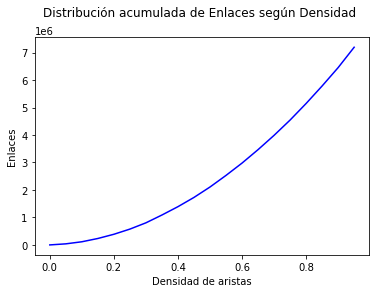

<Figure size 432x288 with 0 Axes>

In [49]:
# plot the cumulative function
plt.plot(edges_distrib[['Densities']].values, edges_distrib[['cumsum_edges']].values, c='blue')
plt.title("Distribución acumulada de Enlaces según Densidad \n")
plt.ylabel("Enlaces")
plt.xlabel('Densidad de aristas')
plt.show()
plt.tight_layout() 

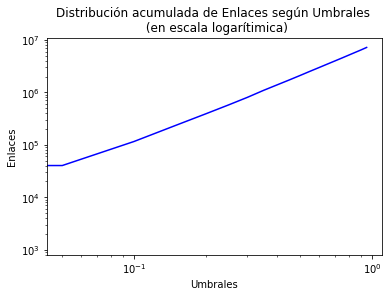

<Figure size 432x288 with 0 Axes>

In [50]:
# grafico distribucion acumulada en escala log 
plt.plot(edges_distrib[['Densities']].values, edges_distrib[['cumsum_edges']].values, c='blue')
plt.yscale('log')
plt.xscale('log')
plt.title("Distribución acumulada de Enlaces según Umbrales \n (en escala logarítimica)")
plt.ylabel("Enlaces")
plt.xlabel('Umbrales')
plt.show()
plt.tight_layout() 

In [51]:
# heatmaps de matrices no ponderadas de grafos a distintas densidades de aristas
def heatmaps_pordensidad(grafos, densidades:list, nro_df, save:bool=False):
    # defino tamaño del gráfico
    plt.figure(figsize=(20,20)) 
    # para cada i (número de orden) y G (los grafos generados anteriormente)
    for i, G in enumerate(grafos): 
        # grilla de 4x5 para visualizar las distintas densidades
        plt.subplot(4,5,i+1) 
        # el heatmap de cada G
        sns.heatmap(nx.to_numpy_array(G), cbar= False, cmap = sns.color_palette("ch:s=-.7,r=.3", as_cmap=True)) 
        # agrego título indicando la densidad
        plt.title('Edge Density: {:0.2}'.format(densidades[i])) 
        # agrego nombre del grafo dentro del cuadro de texto
        G.name = "Grafo con d = " + str(round(densidades[i],2)) 
        # agrego info del grafo para colocar dentro del cuadro de texto
        textstr = nx.info(G) 
        # agrego cuadro de texto
        plt.text(0.6, 0.7, textstr, fontsize=9, bbox=dict(facecolor="white", alpha=0.7)) 
        plt.tight_layout() 
    # guardo los plots generados
    if save:
        folder = os.path.abspath('.').replace('notebooks','figures')
        file_path = os.path.join(folder, f'heatmaps_pordensidad_{densidades}_df{nro_df}.png')
        plt.savefig(file_path)
        plt.close()
        print(f'{file_path} guardado exitosamente.')
    else:
        plt.show()

KeyboardInterrupt: 

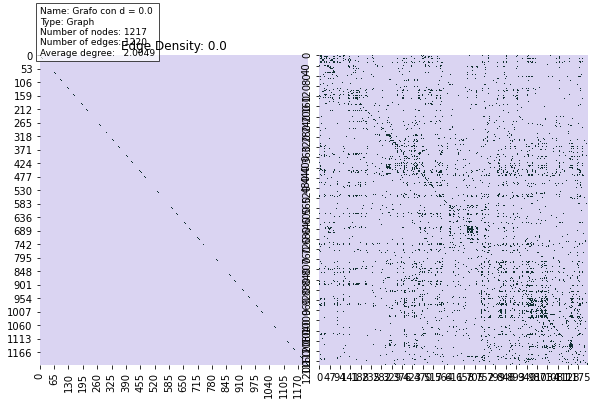

In [80]:
heatmaps_pordensidad(graphs, densities, 1, save=True)

In [ ]:
grafos_pordensidad_dict(, densities)

In [ ]:
plot_heatmap_by_density(data, densidad, list_years, save=False)

**Extracción de medidas de centralidad, grado, camino mínimo, y coeficiente de clustering a partir de los promedios en función de la densidad de aristas**

Al calcular el promedio del camino más corto hay redes que no están conectadas, por lo que para esos casos se calculó el shortest path del máximo componente del grafo. Maca esto es así? (chequear)

In [52]:
def find_shortest_path(graph):
    try:
        shortest = nx.average_shortest_path_length(graph)
    except:
        components_path_length = list()
        for C in (graph.subgraph(c).copy() for c in nx.connected_components(graph)):
            components_path_length.append(nx.average_shortest_path_length(C))
        shortest = np.max(components_path_length)
    return shortest

In [67]:
graphs[1]

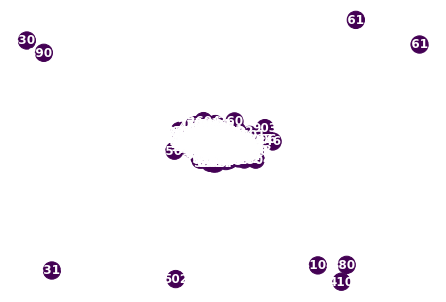

In [68]:
centrality = nx.degree_centrality(graphs[1])
values = [v for n,v in centrality.items()]
nx.draw(graphs[1],with_labels=True, font_weight='bold',node_color = values, font_color='white', edge_color='gray')

In [69]:
g = graphs[1].degree()

In [70]:
dict(g).values()

dict_values([22, 91, 91, 31, 134, 48, 109, 17, 97, 6, 48, 42, 101, 90, 183, 42, 13, 21, 24, 56, 59, 19, 34, 191, 42, 131, 181, 55, 114, 131, 208, 87, 2, 6, 2, 34, 10, 72, 30, 28, 27, 57, 4, 94, 11, 87, 64, 32, 16, 56, 24, 80, 15, 48, 96, 93, 72, 9, 45, 24, 20, 17, 8, 57, 33, 25, 34, 102, 28, 48, 156, 24, 124, 5, 60, 8, 3, 44, 6, 11, 8, 9, 15, 61, 41, 117, 47, 31, 21, 4, 5, 74, 70, 56, 84, 84, 33, 40, 68, 19, 35, 7, 15, 7, 7, 73, 45, 43, 8, 41, 21, 46, 7, 205, 8, 22, 40, 14, 26, 143, 14, 20, 4, 13, 14, 20, 8, 20, 21, 8, 48, 8, 69, 68, 29, 86, 60, 87, 7, 52, 190, 118, 13, 76, 28, 31, 36, 58, 104, 12, 15, 21, 12, 21, 145, 64, 49, 26, 116, 139, 146, 17, 15, 18, 153, 7, 164, 79, 68, 41, 98, 88, 165, 176, 102, 24, 81, 60, 26, 14, 87, 40, 17, 56, 33, 47, 16, 12, 10, 60, 14, 38, 122, 47, 52, 75, 76, 23, 56, 8, 21, 17, 11, 44, 77, 3, 10, 26, 4, 27, 21, 9, 58, 14, 24, 15, 14, 77, 65, 4, 35, 57, 4, 12, 9, 10, 4, 15, 4, 8, 4, 11, 23, 3, 2, 5, 2, 10, 6, 8, 8, 3, 47, 35, 41, 64, 13, 5, 38, 6, 16, 96

In [71]:
graphs[1].number_of_edges()/graphs[1].number_of_nodes()

32.03533278553821

In [72]:
degree = pd.DataFrame.from_dict(graphs[1].degree).rename(columns={0:'from',1:'to'}).T

In [73]:
degree

0    1    2    3    4    5    6    7    8    9     ...  1207  1208  1209  \
from  101  102  103  104  105  106  201  202  203  204  ...  9615  9616  9617   
to     22   91   91   31  134   48  109   17   97    6  ...    26    21    21   

      1210  1211  1212  1213  1214  1215  1216  
from  9618  9701  9702  9703  9704  9705  9706  
to      92    19     8    25    17    44    12  

[2 rows x 1217 columns]

In [74]:
nx.info(graphs[1])

'Name: Grafo con d = 0.05\nType: Graph\nNumber of nodes: 1217\nNumber of edges: 38987\nAverage degree:  64.0707'

In [75]:
degree.loc[ 'to', : ].max()

291

In [76]:
degree.loc[ 'to', : ].mean()

64.07066557107642

In [77]:
pd.DataFrame.from_dict(graphs[1].degree).rename(columns={0:'from',1:'to'}).T.loc[ 'to', : ].max()

291

In [79]:
pd.DataFrame.from_dict(graphs[1].degree).rename(columns={0:'from',1:'to'}).T.loc[ 'to', : ].mean()

64.07066557107642

### Visualización de los grafos

Los autores en el paper original generan una representación en red de la matriz de proximidad para ayudarlos a entender su estructura, así como visualizar y estudiar la dinámica de los países. La matriz que representa el espacio del producto tiene muchos valores pequeños que representan conexiones débiles entre productos. Es por eso que una representación de red se convierte en una forma adecuada de representar los productos, brindando una forma visual rápida de mostrar los enlaces y para determinar dónde se encuentran los países y hacia dónde podrían dirigirse.


**Árbol de expansión máximo (MST)**

Para incluir todos los productos en la red, lo que hacen es generar un "esqueleto": el árbol de expansión máximo (MST, por sus siglas en inglés). Esto no es más que el árbol que contiene una suma de pesos máxima. En otras palabras, es el conjunto de N-1 enlaces (siendo N el número de nodos) el que conecta todos los nodos de la red y maximiza la suma de las proximidades en ella.

In [132]:
G = nx.from_pandas_edgelist(edge_list_1719, source="Pi", target="Pj", edge_attr=["prox"])

In [133]:
print("# of Nodes: {}".format(G.number_of_nodes()))
print("# of Edges: {}".format(G.number_of_edges()))
print("Nodes degree: {}".format(G.degree()))

# of Nodes: 1217
# of Edges: 739936
Nodes degree: [('101', 1216), ('102', 1216), ('103', 1216), ('104', 1216), ('105', 1216), ('106', 1216), ('201', 1216), ('202', 1216), ('203', 1216), ('204', 1216), ('205', 1216), ('206', 1216), ('207', 1216), ('208', 1216), ('209', 1216), ('210', 1216), ('301', 1216), ('302', 1216), ('303', 1216), ('304', 1216), ('305', 1216), ('306', 1216), ('307', 1216), ('401', 1216), ('402', 1216), ('403', 1216), ('404', 1216), ('405', 1216), ('406', 1216), ('407', 1216), ('408', 1216), ('409', 1216), ('410', 1216), ('501', 1216), ('502', 1216), ('504', 1216), ('505', 1216), ('506', 1216), ('507', 1216), ('508', 1216), ('510', 1216), ('511', 1216), ('601', 1216), ('602', 1216), ('603', 1216), ('604', 1216), ('701', 1216), ('702', 1216), ('703', 1216), ('704', 1216), ('705', 1216), ('706', 1216), ('707', 1216), ('708', 1216), ('709', 1216), ('710', 1216), ('711', 1216), ('712', 1216), ('713', 1216), ('714', 1216), ('801', 1216), ('802', 1216), ('803', 1216), ('80

In [135]:
CG = nx.connected_components(G)

In [134]:
for n, nbrs in G.adj.items():
    for nbr, eattr in nbrs.items():
        wt = eattr['prox']
        if wt >= 0.55: print(f"({n}, {nbr}, {wt:.3})")

(101, 3502, 0.647)
(101, 9021, 0.588)
(102, 401, 0.583)
(102, 8002, 0.556)
(103, 1520, 0.55)
(105, 407, 0.633)
(105, 1601, 0.6)
(105, 3402, 0.667)
(105, 7310, 0.559)
(105, 7612, 0.556)
(201, 206, 0.636)
(201, 404, 0.591)
(201, 504, 0.591)
(201, 1602, 0.556)
(201, 1901, 0.609)
(201, 8433, 0.591)
(202, 206, 0.571)
(202, 1502, 0.667)
(203, 209, 0.667)
(203, 210, 0.615)
(203, 1501, 0.643)
(205, 506, 0.577)
(206, 201, 0.636)
(206, 202, 0.571)
(206, 504, 0.714)
(206, 511, 0.552)
(207, 1602, 0.593)
(209, 203, 0.667)
(209, 404, 0.619)
(209, 408, 0.611)
(209, 1501, 0.667)
(209, 3006, 0.556)
(209, 4004, 0.565)
(209, 5602, 0.571)
(209, 5911, 0.611)
(209, 8421, 0.556)
(209, 8422, 0.556)
(209, 8433, 0.591)
(209, 8436, 0.611)
(209, 8701, 0.556)
(209, 8707, 0.556)
(210, 203, 0.615)
(210, 4304, 0.615)
(302, 303, 0.625)
(302, 304, 0.588)
(303, 302, 0.625)
(303, 304, 0.735)
(303, 307, 0.562)
(303, 1605, 0.562)
(303, 2301, 0.688)
(304, 302, 0.588)
(304, 303, 0.735)
(304, 305, 0.618)
(304, 307, 0.559)
(30

(3213, 9003, 0.562)
(3213, 9618, 0.625)
(3214, 1602, 0.556)
(3214, 1806, 0.593)
(3214, 3004, 0.556)
(3214, 3208, 0.625)
(3214, 3209, 0.667)
(3214, 3814, 0.593)
(3214, 3816, 0.593)
(3214, 3917, 0.562)
(3214, 3921, 0.593)
(3214, 3925, 0.581)
(3214, 4008, 0.556)
(3214, 4808, 0.593)
(3214, 4911, 0.586)
(3214, 5602, 0.556)
(3214, 7310, 0.559)
(3302, 1503, 0.636)
(3302, 3001, 0.583)
(3303, 3304, 0.6)
(3304, 3303, 0.6)
(3304, 4901, 0.6)
(3305, 1904, 0.556)
(3305, 1905, 0.595)
(3305, 2309, 0.568)
(3305, 3208, 0.556)
(3305, 3307, 0.639)
(3305, 3402, 0.611)
(3305, 3920, 0.583)
(3305, 3923, 0.644)
(3305, 4819, 0.595)
(3305, 4821, 0.583)
(3305, 4822, 0.639)
(3305, 7308, 0.556)
(3305, 7310, 0.583)
(3305, 7610, 0.556)
(3305, 7612, 0.611)
(3306, 3307, 0.577)
(3307, 2104, 0.552)
(3307, 3305, 0.639)
(3307, 3306, 0.577)
(3307, 6809, 0.571)
(3307, 8418, 0.577)
(3402, 105, 0.667)
(3402, 403, 0.556)
(3402, 1704, 0.564)
(3402, 1904, 0.571)
(3402, 1905, 0.619)
(3402, 2105, 0.559)
(3402, 3209, 0.606)
(3402, 3

(4417, 4808, 0.56)
(4417, 4820, 0.567)
(4417, 4823, 0.6)
(4417, 7314, 0.552)
(4417, 9403, 0.6)
(4418, 1601, 0.633)
(4418, 3917, 0.562)
(4418, 3925, 0.581)
(4418, 4401, 0.613)
(4418, 4407, 0.613)
(4418, 4408, 0.6)
(4418, 4409, 0.667)
(4418, 4415, 0.564)
(4418, 4822, 0.567)
(4418, 7309, 0.562)
(4418, 7610, 0.633)
(4418, 8432, 0.6)
(4418, 9403, 0.667)
(4418, 9406, 0.567)
(4421, 9403, 0.56)
(4502, 4503, 0.6)
(4503, 4502, 0.6)
(4701, 8401, 0.571)
(4707, 1904, 0.553)
(4707, 1905, 0.571)
(4707, 2106, 0.632)
(4707, 2309, 0.579)
(4707, 3915, 0.578)
(4707, 4415, 0.564)
(4707, 4821, 0.553)
(4707, 7204, 0.578)
(4803, 8544, 0.571)
(4805, 4016, 0.56)
(4805, 4822, 0.607)
(4805, 8432, 0.625)
(4805, 8708, 0.583)
(4808, 3209, 0.577)
(4808, 3212, 0.565)
(4808, 3214, 0.593)
(4808, 3917, 0.562)
(4808, 4417, 0.56)
(4808, 4823, 0.652)
(4808, 4902, 0.565)
(4808, 7215, 0.609)
(4810, 7218, 0.636)
(4810, 8462, 0.583)
(4811, 3809, 0.591)
(4811, 6905, 0.55)
(4811, 8408, 0.55)
(4813, 1518, 0.56)
(4813, 2509, 0.56)


(6110, 4203, 0.583)
(6110, 6101, 0.68)
(6110, 6102, 0.621)
(6110, 6103, 0.72)
(6110, 6104, 0.833)
(6110, 6105, 0.72)
(6110, 6106, 0.656)
(6110, 6107, 0.625)
(6110, 6108, 0.625)
(6110, 6109, 0.633)
(6110, 6111, 0.583)
(6110, 6203, 0.688)
(6110, 6204, 0.793)
(6110, 6205, 0.8)
(6110, 6206, 0.667)
(6110, 6207, 0.667)
(6110, 6208, 0.667)
(6110, 6209, 0.667)
(6110, 6211, 0.68)
(6110, 6401, 0.625)
(6110, 6405, 0.577)
(6111, 4203, 0.684)
(6111, 6103, 0.56)
(6111, 6104, 0.609)
(6111, 6105, 0.64)
(6111, 6108, 0.55)
(6111, 6110, 0.583)
(6111, 6114, 0.684)
(6111, 6207, 0.6)
(6111, 6209, 0.682)
(6112, 4203, 0.55)
(6112, 5510, 0.55)
(6112, 6102, 0.552)
(6112, 6104, 0.565)
(6112, 6207, 0.55)
(6112, 6208, 0.65)
(6112, 6912, 0.6)
(6112, 8712, 0.55)
(6113, 4017, 0.55)
(6114, 4203, 0.579)
(6114, 6104, 0.609)
(6114, 6105, 0.6)
(6114, 6111, 0.684)
(6114, 6207, 0.55)
(6114, 6208, 0.55)
(6114, 6209, 0.682)
(6114, 6211, 0.6)
(6115, 6107, 0.591)
(6115, 6406, 0.636)
(6201, 8712, 0.6)
(6202, 9405, 0.583)
(6203, 

(7301, 6808, 0.571)
(7305, 2503, 0.562)
(7306, 403, 0.583)
(7306, 3917, 0.588)
(7306, 7214, 0.618)
(7306, 7216, 0.588)
(7306, 7217, 0.618)
(7306, 7308, 0.559)
(7306, 7309, 0.559)
(7307, 3926, 0.56)
(7307, 4823, 0.609)
(7307, 8468, 0.571)
(7307, 8906, 0.571)
(7308, 401, 0.647)
(7308, 403, 0.611)
(7308, 3305, 0.556)
(7308, 3920, 0.588)
(7308, 3921, 0.588)
(7308, 3925, 0.706)
(7308, 4415, 0.641)
(7308, 4819, 0.595)
(7308, 4821, 0.556)
(7308, 4822, 0.647)
(7308, 7306, 0.559)
(7308, 7309, 0.618)
(7308, 7310, 0.588)
(7308, 7314, 0.559)
(7308, 7326, 0.647)
(7308, 7604, 0.588)
(7308, 7610, 0.676)
(7308, 7612, 0.556)
(7308, 8544, 0.559)
(7308, 9403, 0.559)
(7308, 9406, 0.618)
(7309, 1601, 0.594)
(7309, 3402, 0.576)
(7309, 3917, 0.562)
(7309, 3921, 0.562)
(7309, 3922, 0.594)
(7309, 3925, 0.562)
(7309, 4415, 0.59)
(7309, 4418, 0.562)
(7309, 4821, 0.556)
(7309, 4911, 0.594)
(7309, 6809, 0.562)
(7309, 7306, 0.559)
(7309, 7308, 0.618)
(7309, 7310, 0.588)
(7309, 7326, 0.594)
(7309, 7610, 0.562)
(7309

(8417, 3922, 0.636)
(8417, 4906, 0.562)
(8417, 7222, 0.562)
(8417, 7228, 0.647)
(8417, 7324, 0.688)
(8417, 8208, 0.556)
(8417, 8301, 0.625)
(8417, 8302, 0.562)
(8417, 8419, 0.562)
(8417, 8438, 0.562)
(8417, 8454, 0.562)
(8417, 8455, 0.562)
(8417, 8465, 0.562)
(8417, 8474, 0.583)
(8417, 8480, 0.562)
(8417, 8481, 0.611)
(8417, 8483, 0.562)
(8417, 8501, 0.588)
(8417, 8503, 0.6)
(8417, 8515, 0.562)
(8418, 3307, 0.577)
(8418, 3922, 0.56)
(8418, 3926, 0.6)
(8418, 4011, 0.56)
(8418, 4016, 0.56)
(8418, 7321, 0.56)
(8418, 7326, 0.567)
(8418, 8309, 0.577)
(8418, 8311, 0.6)
(8418, 8432, 0.56)
(8418, 8708, 0.6)
(8418, 9403, 0.6)
(8418, 9406, 0.552)
(8419, 5911, 0.611)
(8419, 6805, 0.632)
(8419, 7222, 0.562)
(8419, 8207, 0.562)
(8419, 8208, 0.611)
(8419, 8408, 0.562)
(8419, 8409, 0.562)
(8419, 8413, 0.562)
(8419, 8416, 0.562)
(8419, 8417, 0.562)
(8419, 8422, 0.562)
(8419, 8479, 0.562)
(8419, 8481, 0.667)
(8419, 8483, 0.562)
(8419, 8501, 0.588)
(8419, 8515, 0.625)
(8419, 8526, 0.556)
(8419, 9024, 0.

(8538, 4009, 0.55)
(8538, 4016, 0.6)
(8538, 7008, 0.55)
(8538, 8511, 0.55)
(8538, 8512, 0.6)
(8538, 8536, 0.55)
(8538, 8607, 0.55)
(8538, 8708, 0.619)
(8538, 9026, 0.55)
(8541, 3818, 0.714)
(8541, 7006, 0.857)
(8541, 7410, 0.857)
(8541, 8470, 0.625)
(8541, 8473, 0.857)
(8541, 8505, 0.556)
(8541, 8522, 0.556)
(8541, 8529, 0.556)
(8541, 8534, 0.75)
(8541, 8542, 0.6)
(8541, 8543, 0.75)
(8541, 9002, 0.7)
(8541, 9013, 0.714)
(8541, 9110, 0.714)
(8541, 9111, 0.571)
(8541, 9114, 0.571)
(8542, 7006, 0.6)
(8542, 8473, 0.6)
(8542, 8529, 0.6)
(8542, 8532, 0.636)
(8542, 8541, 0.6)
(8542, 8543, 0.6)
(8542, 9002, 0.7)
(8543, 7006, 0.625)
(8543, 7410, 0.625)
(8543, 8443, 0.556)
(8543, 8470, 0.625)
(8543, 8473, 0.625)
(8543, 8522, 0.556)
(8543, 8529, 0.556)
(8543, 8534, 0.625)
(8543, 8541, 0.75)
(8543, 8542, 0.6)
(8543, 9002, 0.7)
(8543, 9110, 0.625)
(8544, 811, 0.586)
(8544, 1601, 0.567)
(8544, 3925, 0.581)
(8544, 4408, 0.571)
(8544, 4803, 0.571)
(8544, 4817, 0.571)
(8544, 4818, 0.552)
(8544, 4822, 0

(9615, 4903, 0.571)
(9615, 6702, 0.6)
(9615, 8214, 0.6)
(9615, 8513, 0.6)
(9616, 6602, 0.571)
(9618, 3213, 0.625)
(9704, 3822, 0.571)
(9705, 3002, 0.583)
(9705, 9706, 0.583)
(9706, 9705, 0.583)


In [137]:
T = nx.maximum_spanning_tree(G, weight='prox')
T

In [138]:
min_T = nx.minimum_spanning_tree(G, weight='prox')
min_T

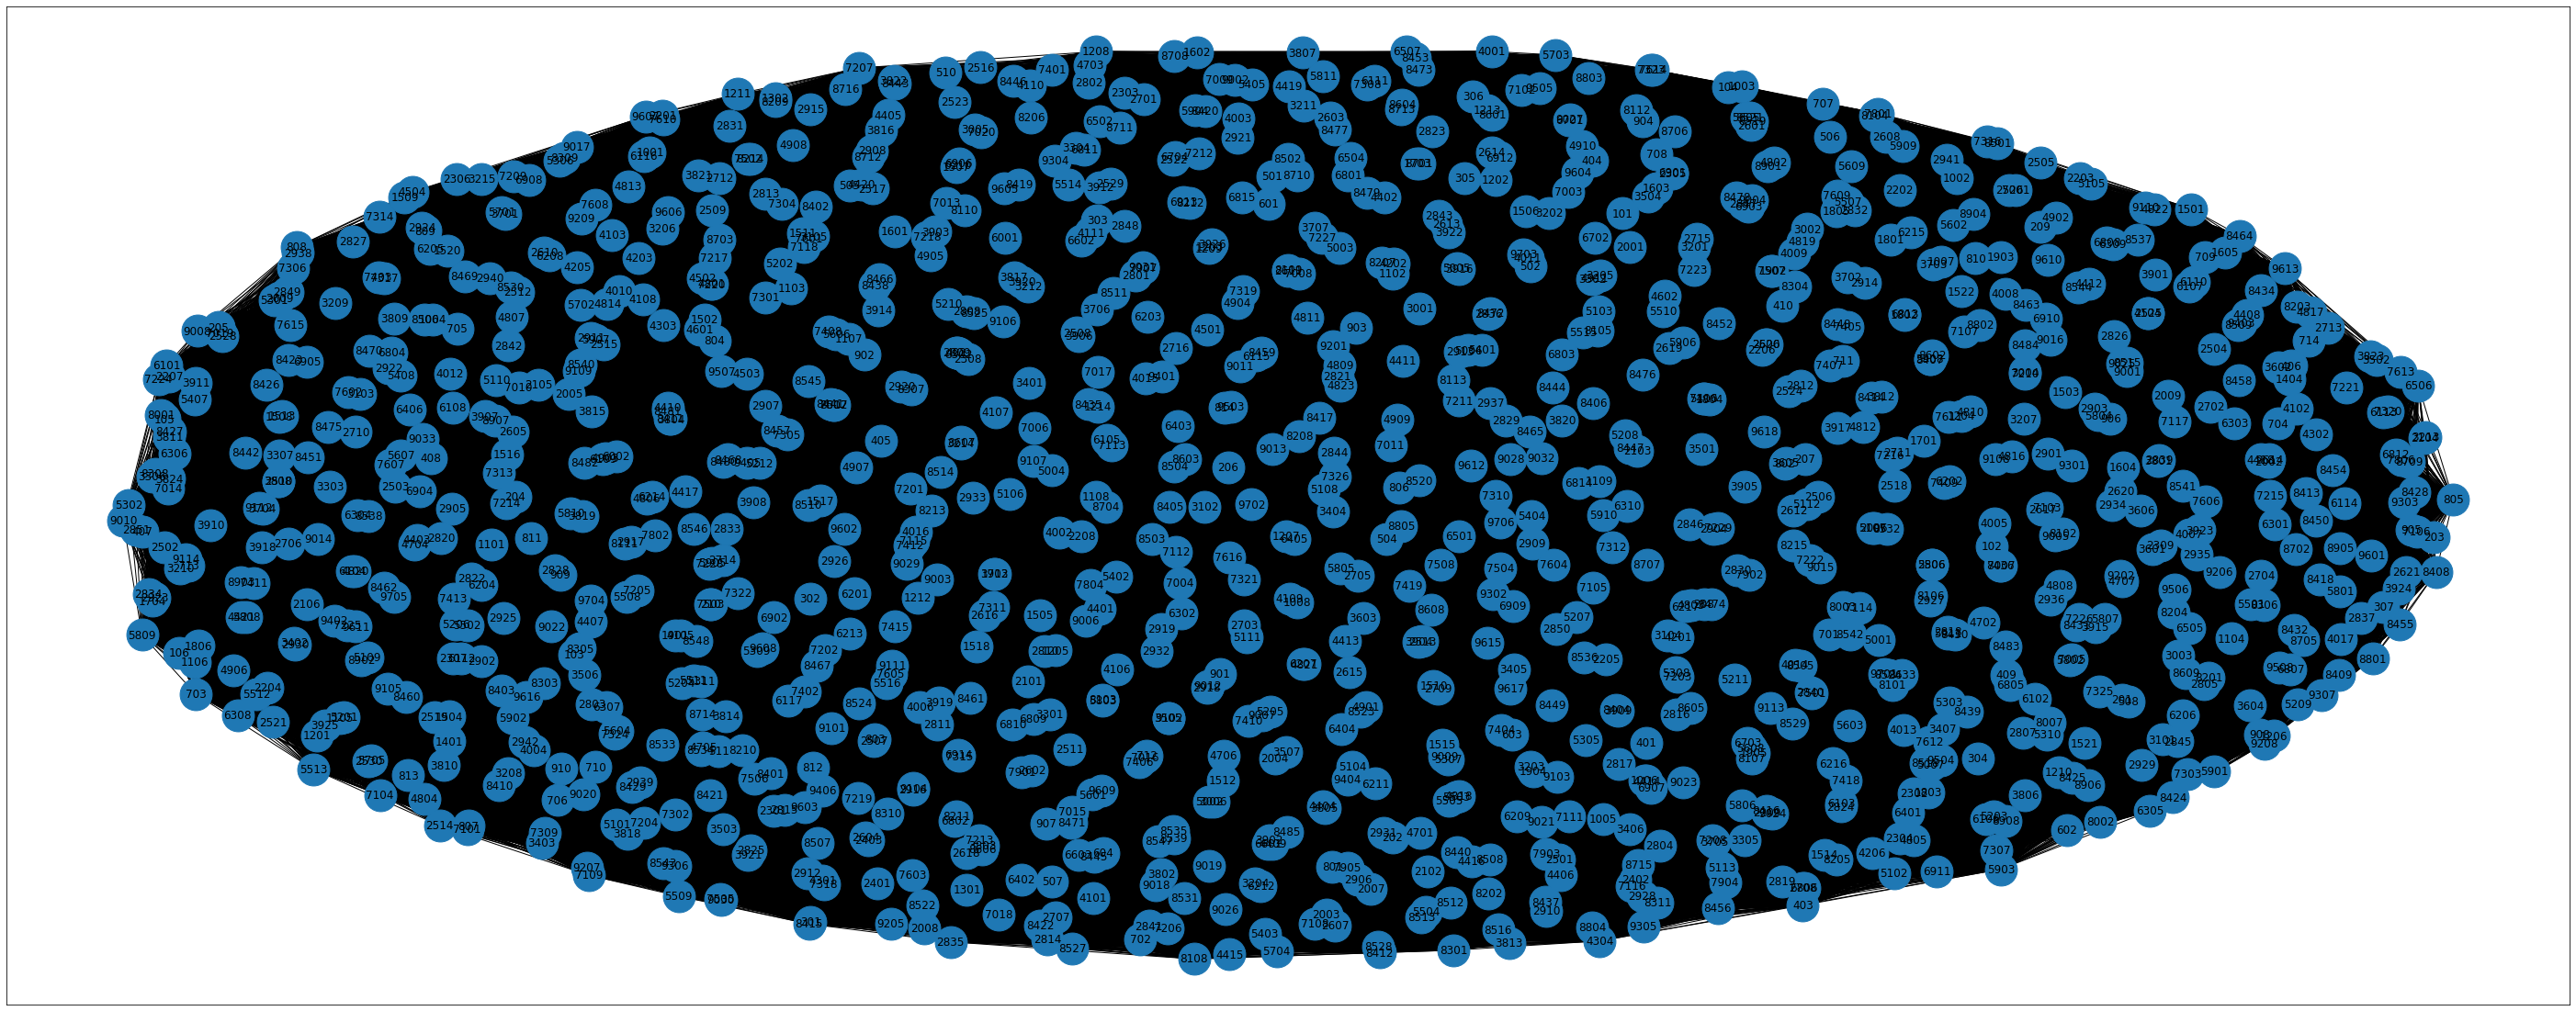

In [140]:
fig = plt.figure(figsize=(50,20))
ax = fig.gca()
nx.draw_networkx(G, ax=ax, pos=nx.spring_layout(G,k=0.2), node_size=1217, width=1)

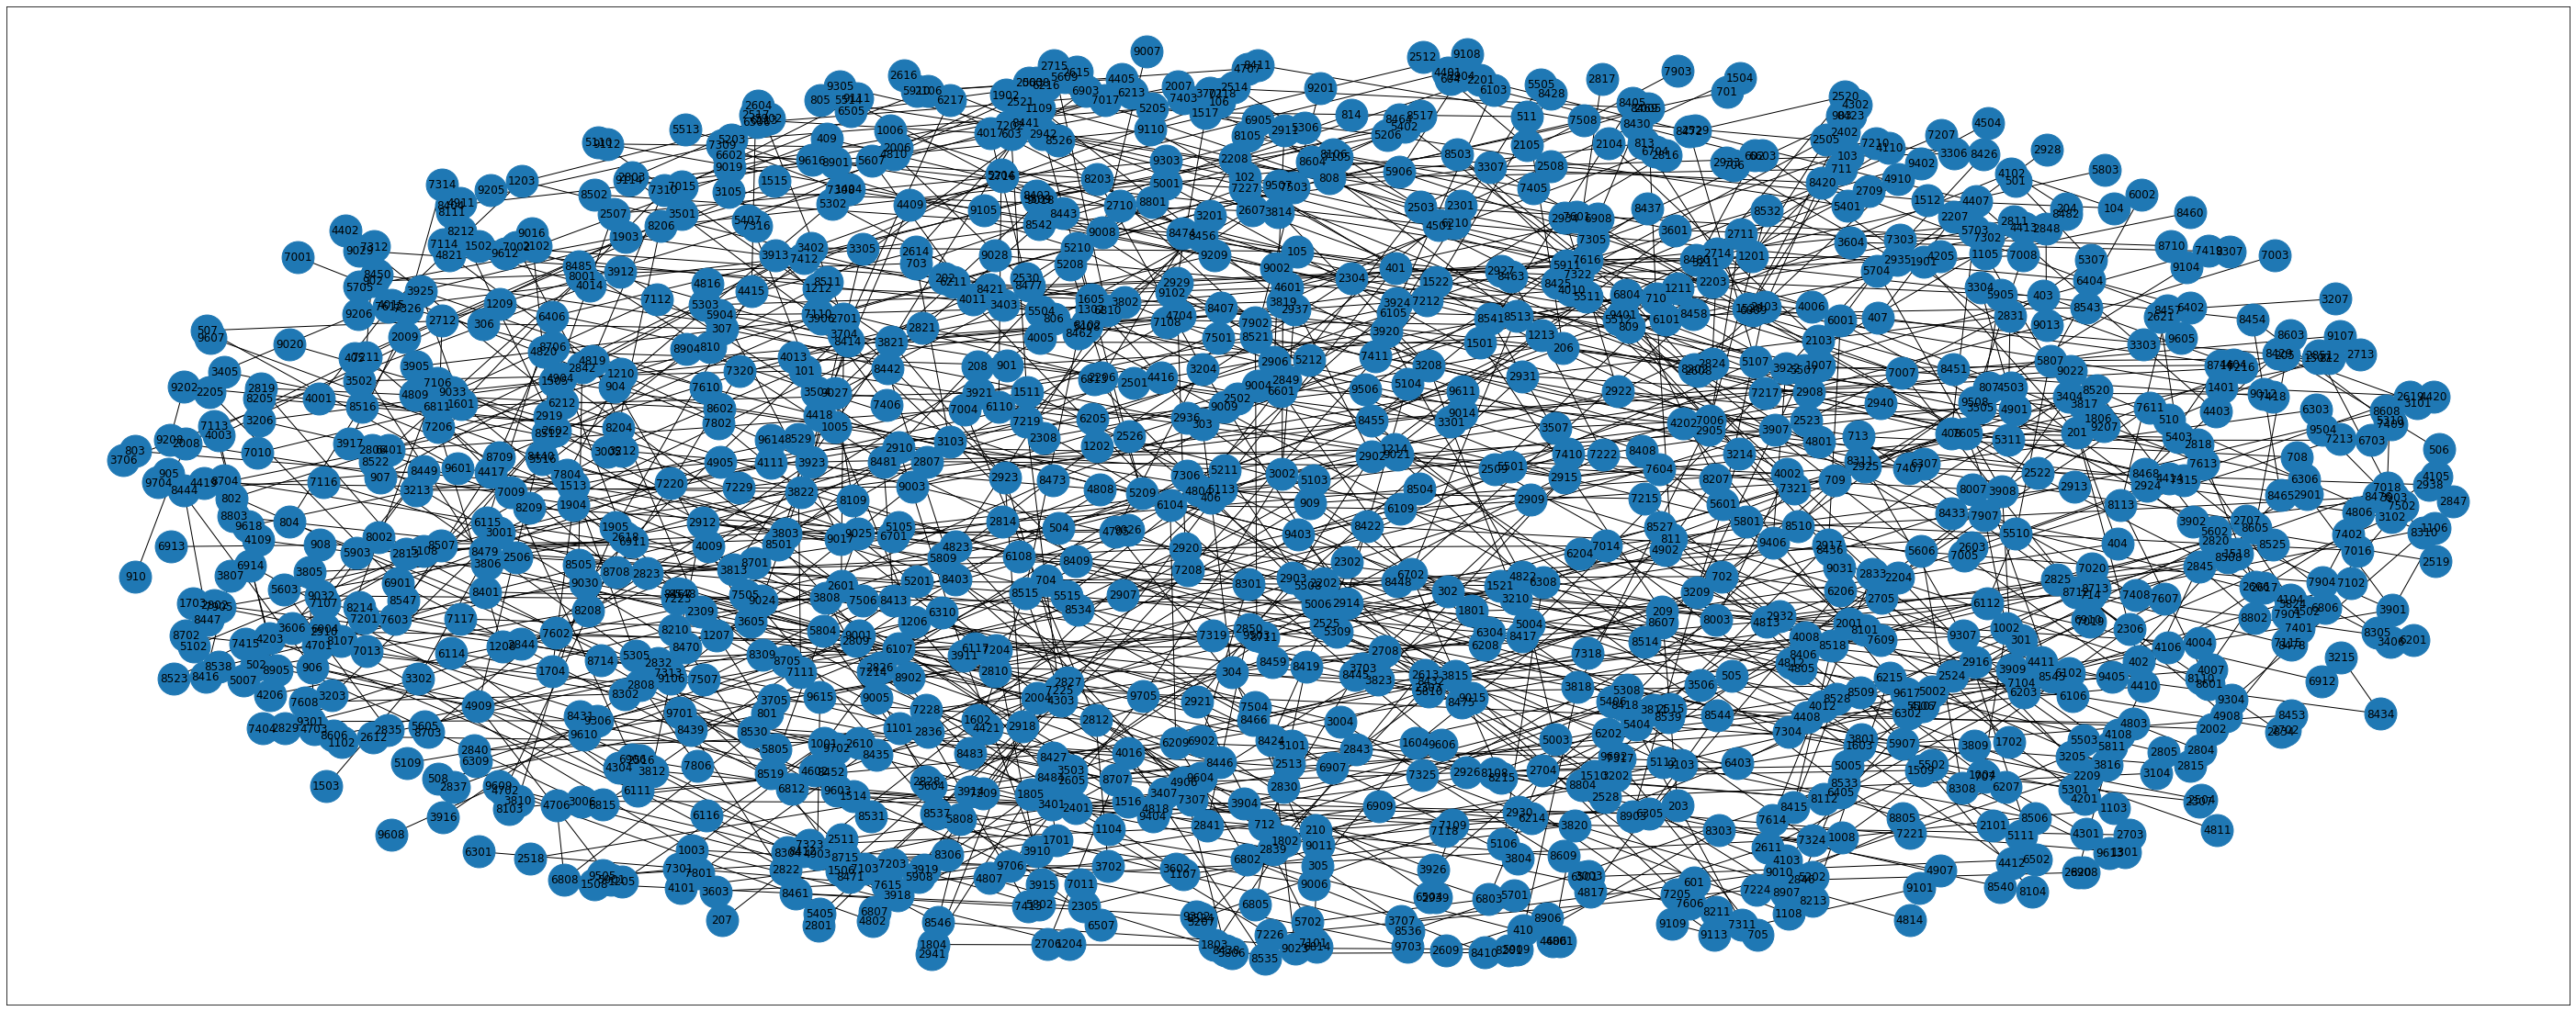

In [141]:
fig = plt.figure(figsize=(50,20))
ax = fig.gca()
nx.draw_networkx(T, ax=ax, pos=nx.spring_layout(T,k=0.2), node_size=1217, width=1)

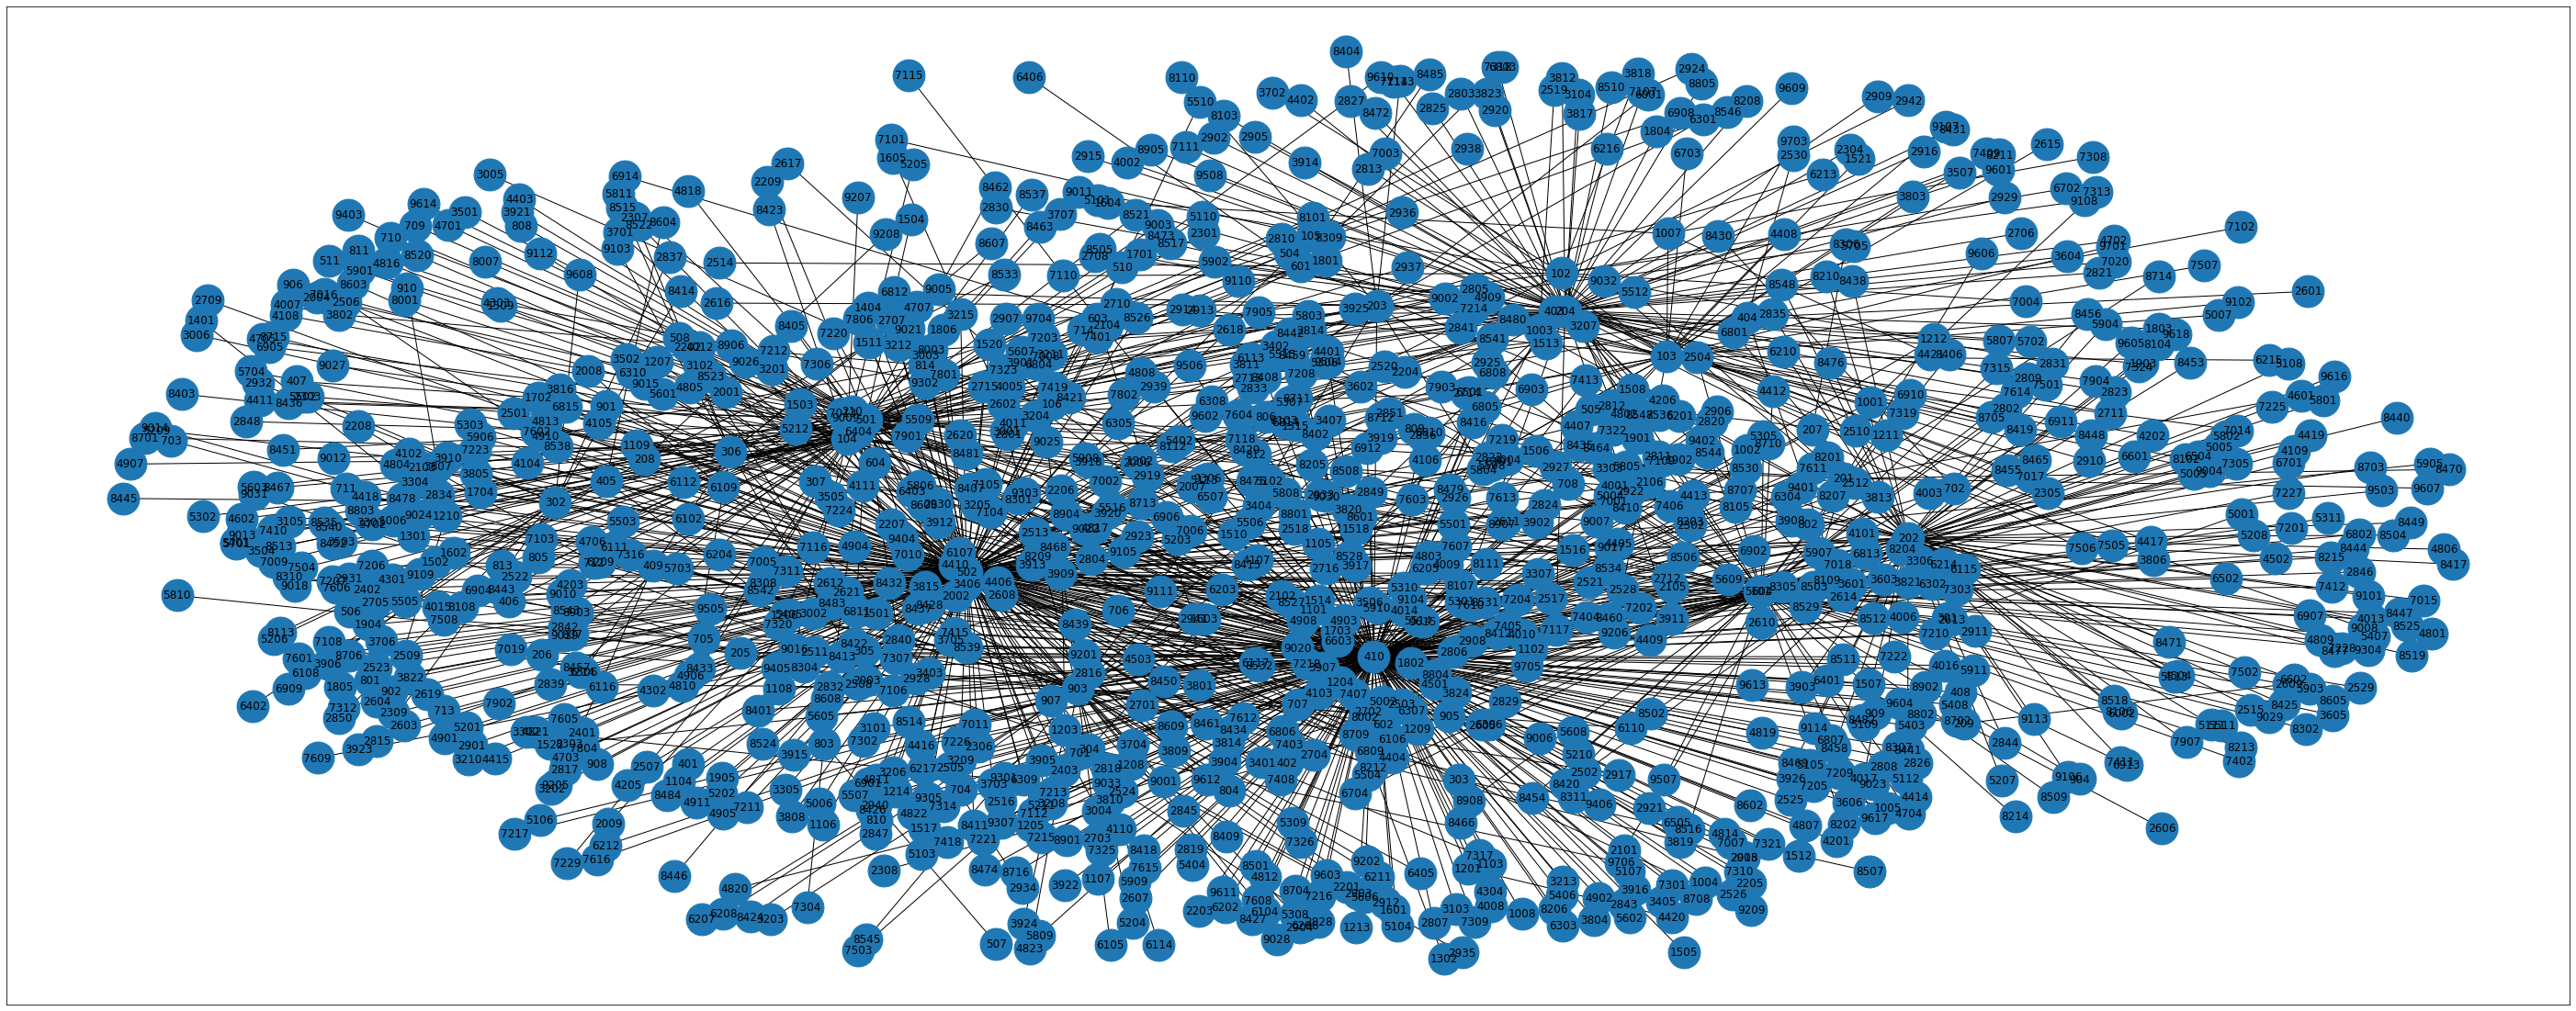

In [144]:
fig = plt.figure(figsize=(50,20))
ax = fig.gca()
nx.draw_networkx(min_T, ax=ax, pos=nx.spring_layout(min_T,k=0.2), node_size=1217, width=1)

In [158]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1217
Number of edges: 739936
Average degree: 1216.0000


In [159]:
print(nx.info(T))
print(nx.info(min_T))

Name: 
Type: Graph
Number of nodes: 1217
Number of edges: 1216
Average degree:   1.9984
Name: 
Type: Graph
Number of nodes: 1217
Number of edges: 1216
Average degree:   1.9984


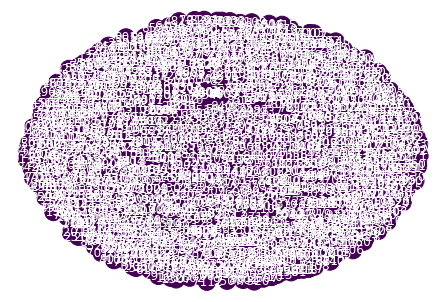

In [160]:
values = [v for v in nx.clustering(G).values()]
nx.draw(G,pos=nx.spring_layout(G,k=0.2), with_labels=True, node_color = values, font_color='white', edge_color='gray')

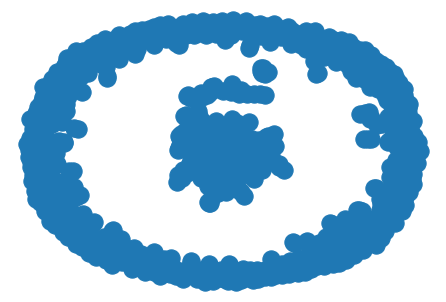

In [161]:
F = G.copy()
threshold = 0.55
F.remove_edges_from([(n1, n2) for n1, n2, w in F.edges(data="prox") if w <= threshold])
nx.draw(F)
plt.show()

In [ ]:
# def slice_network(G, T, data = True):
#     """ Remove all edges with weight<T from G or its copy. """
#     F = G.copy() if copy else G
#     F.remove_edges_from([(n1, n2) for n1, n2, w in F.edges(data="weight") if w < T])
#     return F